# Mortgage Forecasting - Model Building
## Time Series Model Development and Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Time series specific
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from prophet import Prophet

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Load and Prepare Data

Data Overview:
Time period: 2018-03-31 23:59:59.999999999 to 2024-09-30 23:59:59.999999999
Total quarters: 27


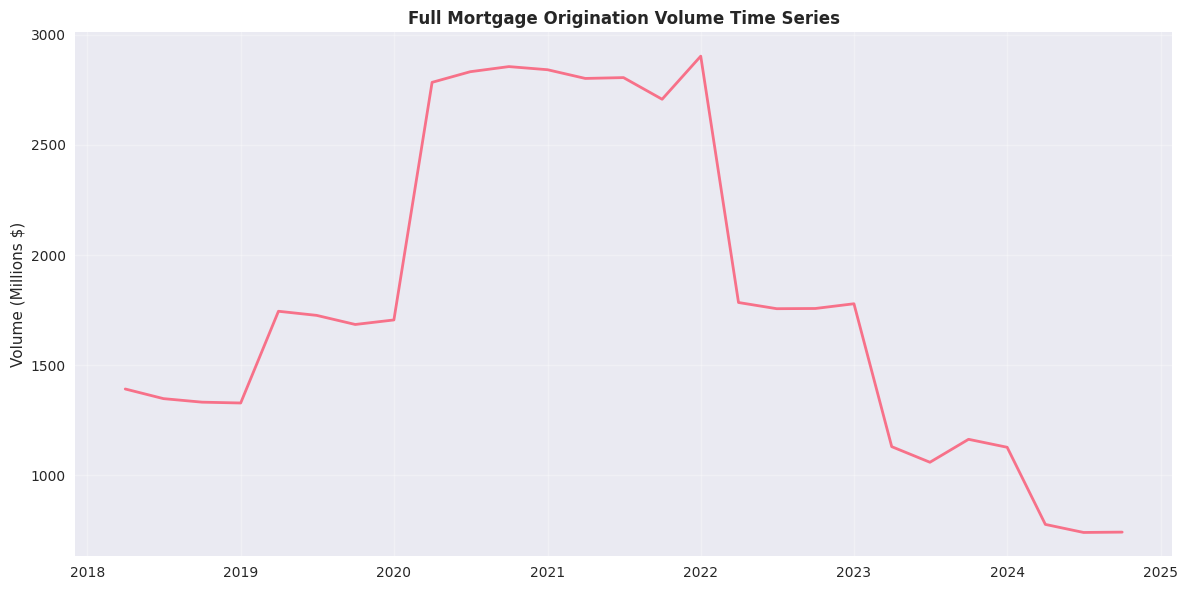

In [2]:
# Load processed data
data_path = "../data/processed/quarterly_mortgage_volume.csv"
quarterly_data = pd.read_csv(data_path, parse_dates=['date'])

print("Data Overview:")
print(f"Time period: {quarterly_data['date'].min()} to {quarterly_data['date'].max()}")
print(f"Total quarters: {len(quarterly_data)}")

# Prepare the time series
ts_data = quarterly_data.set_index('date')['total_loan_volume']
ts_data = ts_data.asfreq('Q')

# Plot the full series
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data.values / 1e6, linewidth=2)
plt.title('Full Mortgage Origination Volume Time Series', fontweight='bold')
plt.ylabel('Volume (Millions $)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Train-Test Split

Training set: 2018-03-31 23:59:59.999999999 to 2023-06-30 23:59:59.999999999 (22 quarters)
Test set: 2023-09-30 23:59:59.999999999 to 2024-09-30 23:59:59.999999999 (5 quarters)


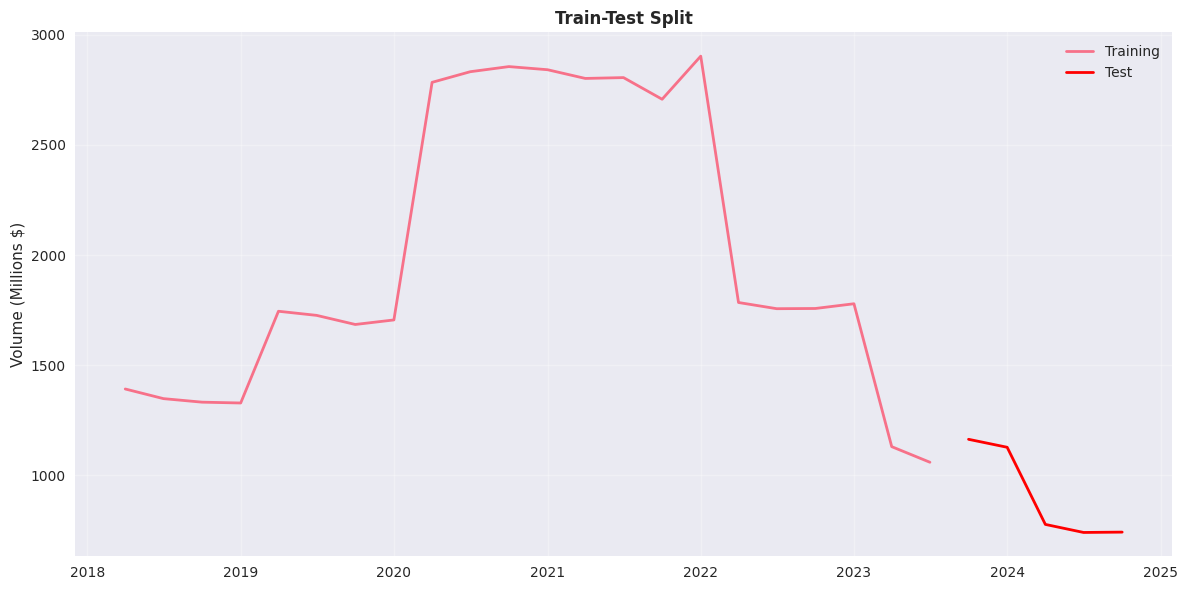

In [3]:
def train_test_split_timeseries(data, test_size=0.2):
    """Split time series into train and test sets"""
    n_test = int(len(data) * test_size)
    
    train = data.iloc[:-n_test]
    test = data.iloc[-n_test:]
    
    print(f"Training set: {train.index.min()} to {train.index.max()} ({len(train)} quarters)")
    print(f"Test set: {test.index.min()} to {test.index.max()} ({len(test)} quarters)")
    
    return train, test

# Split the data
train_data, test_data = train_test_split_timeseries(ts_data, test_size=0.2)

# Plot train-test split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values / 1e6, label='Training', linewidth=2)
plt.plot(test_data.index, test_data.values / 1e6, label='Test', linewidth=2, color='red')
plt.title('Train-Test Split', fontweight='bold')
plt.ylabel('Volume (Millions $)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. SARIMA Model

In [4]:
def build_sarima_model(train_data, seasonal_period=4):
    """Build SARIMA model using auto_arima for parameter selection"""
    print("Building SARIMA model...")
    
    # Use auto_arima to find best parameters
    model = auto_arima(
        train_data,
        seasonal=True,
        m=seasonal_period,  # quarterly data
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        trace=True,
        n_jobs=-1
    )
    
    print(f"\nBest SARIMA parameters: {model.order} {model.seasonal_order}")
    
    return model

# Build SARIMA model
sarima_model = build_sarima_model(train_data)

# Generate forecasts
sarima_forecast = sarima_model.predict(n_periods=len(test_data))
sarima_forecast_index = pd.date_range(
    start=test_data.index[0], 
    periods=len(test_data), 
    freq='Q'
)
sarima_forecast = pd.Series(sarima_forecast, index=sarima_forecast_index)

print(f"SARIMA forecast for test period complete")
print(f"Forecast range: {sarima_forecast.index.min()} to {sarima_forecast.index.max()}")

Building SARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=726.990, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=729.611, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=729.898, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=727.796, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=740.786, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=1646.846, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=728.347, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=728.437, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=730.410, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=728.024, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 0.935 seconds

Best SARIMA parameters: (0, 1, 0) (0, 1, 0, 4)
SARIMA forecast for test period complete
Forecast range: 2023-09-30 23:59:59.999999999 to 2024-

## 4. Facebook Prophet Model

In [5]:
def build_prophet_model(train_data):
    """Build Facebook Prophet model"""
    print("Building Prophet model...")
    
    # Prepare data for Prophet
    prophet_train = train_data.reset_index()
    prophet_train.columns = ['ds', 'y']
    
    # Create and fit model
    model = Prophet(
        yearly_seasonality=True,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10
    )
    
    model.fit(prophet_train)
    
    return model

# Build Prophet model
prophet_model = build_prophet_model(train_data)

# Generate forecasts
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='Q')
prophet_forecast = prophet_model.predict(future)

# Extract the forecast for test period
prophet_test_forecast = prophet_forecast[prophet_forecast['ds'].isin(test_data.index)]
prophet_forecast_series = pd.Series(
    prophet_test_forecast['yhat'].values, 
    index=prophet_test_forecast['ds']
)

print(f"Prophet forecast for test period complete")

20:29:39 - cmdstanpy - INFO - Chain [1] start processing
20:29:39 - cmdstanpy - INFO - Chain [1] done processing


Building Prophet model...
Prophet forecast for test period complete


## 5. Exponential Smoothing (ETS) Model

In [6]:
def build_ets_model(train_data, seasonal_period=4):
    """Build Exponential Smoothing model"""
    print("Building Exponential Smoothing model...")
    
    # Try different configurations
    best_aic = np.inf
    best_model = None
    
    # Test additive vs multiplicative seasonality
    for seasonal in ['add', 'mul']:
        try:
            model = ExponentialSmoothing(
                train_data,
                seasonal_periods=seasonal_period,
                trend='add',
                seasonal=seasonal
            ).fit()
            
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
                best_seasonal = seasonal
        except:
            continue
    
    if best_model is not None:
        print(f"Best ETS model: Additive trend with {best_seasonal} seasonality")
        print(f"AIC: {best_aic:.2f}")
    else:
        # Fallback to simple model
        print("Using fallback ETS model")
        best_model = ExponentialSmoothing(train_data).fit()
    
    return best_model

# Build ETS model
ets_model = build_ets_model(train_data)

# Generate forecasts
ets_forecast = ets_model.forecast(len(test_data))
ets_forecast = pd.Series(ets_forecast, index=test_data.index)

print(f"ETS forecast for test period complete")

Building Exponential Smoothing model...
Best ETS model: Additive trend with mul seasonality
AIC: 884.70
ETS forecast for test period complete


## 6. Baseline Models

In [7]:
def build_baseline_models(train_data, test_data):
    """Build simple baseline models for comparison"""
    baselines = {}
    
    # 1. Naive forecast (last value)
    last_value = train_data.iloc[-1]
    baselines['naive'] = pd.Series([last_value] * len(test_data), index=test_data.index)
    
    # 2. Seasonal naive (last year same quarter)
    seasonal_naive = []
    for date in test_data.index:
        # Get same quarter from previous year
        prev_year_date = date - pd.DateOffset(years=1)
        if prev_year_date in train_data.index:
            seasonal_naive.append(train_data.loc[prev_year_date])
        else:
            # Fallback to naive if not available
            seasonal_naive.append(last_value)
    
    baselines['seasonal_naive'] = pd.Series(seasonal_naive, index=test_data.index)
    
    # 3. Moving average (4-quarter)
    if len(train_data) >= 4:
        moving_avg = train_data.rolling(window=4).mean().iloc[-1]
    else:
        moving_avg = train_data.mean()
    
    baselines['moving_avg'] = pd.Series([moving_avg] * len(test_data), index=test_data.index)
    
    print("Baseline models created:")
    for name in baselines.keys():
        print(f"  • {name}")
    
    return baselines

# Build baseline models
baseline_models = build_baseline_models(train_data, test_data)

Baseline models created:
  • naive
  • seasonal_naive
  • moving_avg


## 7. Model Comparison and Evaluation

In [8]:
def evaluate_models(test_data, forecasts_dict):
    """Evaluate all models and return metrics"""
    results = {}
    
    for model_name, forecast in forecasts_dict.items():
        # Ensure we only compare available test periods
        common_index = test_data.index.intersection(forecast.index)
        
        if len(common_index) == 0:
            print(f"Warning: No common dates for {model_name}")
            continue
            
        actual = test_data.loc[common_index]
        predicted = forecast.loc[common_index]
        
        # Calculate metrics
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        
        results[model_name] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'Accuracy': max(0, 100 - mape)  # Simplified accuracy
        }
    
    return pd.DataFrame(results).T

# Combine all forecasts
all_forecasts = {
    'SARIMA': sarima_forecast,
    'Prophet': prophet_forecast_series,
    'ETS': ets_forecast,
    'Naive': baseline_models['naive'],
    'Seasonal_Naive': baseline_models['seasonal_naive'],
    'Moving_Avg': baseline_models['moving_avg']
}

# Evaluate all models
model_evaluation = evaluate_models(test_data, all_forecasts)

print("Model Performance Comparison:")
display(model_evaluation.round(3))

# Identify best model
best_model_name = model_evaluation['Accuracy'].idxmax()
best_accuracy = model_evaluation.loc[best_model_name, 'Accuracy']

print(f"\n🏆 Best Model: {best_model_name} ({best_accuracy:.2f}% accuracy)")

Model Performance Comparison:


,MAE,RMSE,MAPE,Accuracy
SARIMA,2.500300e+08,2.890834e+08,31.836,68.164
Prophet,1.754337e+09,2.052267e+09,224.611,0.000
ETS,4.466415e+08,4.655864e+08,52.603,47.397
Naive,2.179640e+08,2.437250e+08,27.376,72.624
Seasonal_Naive,4.466940e+08,4.697224e+08,47.950,52.050
Moving_Avg,5.210965e+08,5.556234e+08,63.988,36.012



🏆 Best Model: Naive (72.62% accuracy)


## 8. Visualization of Model Performance

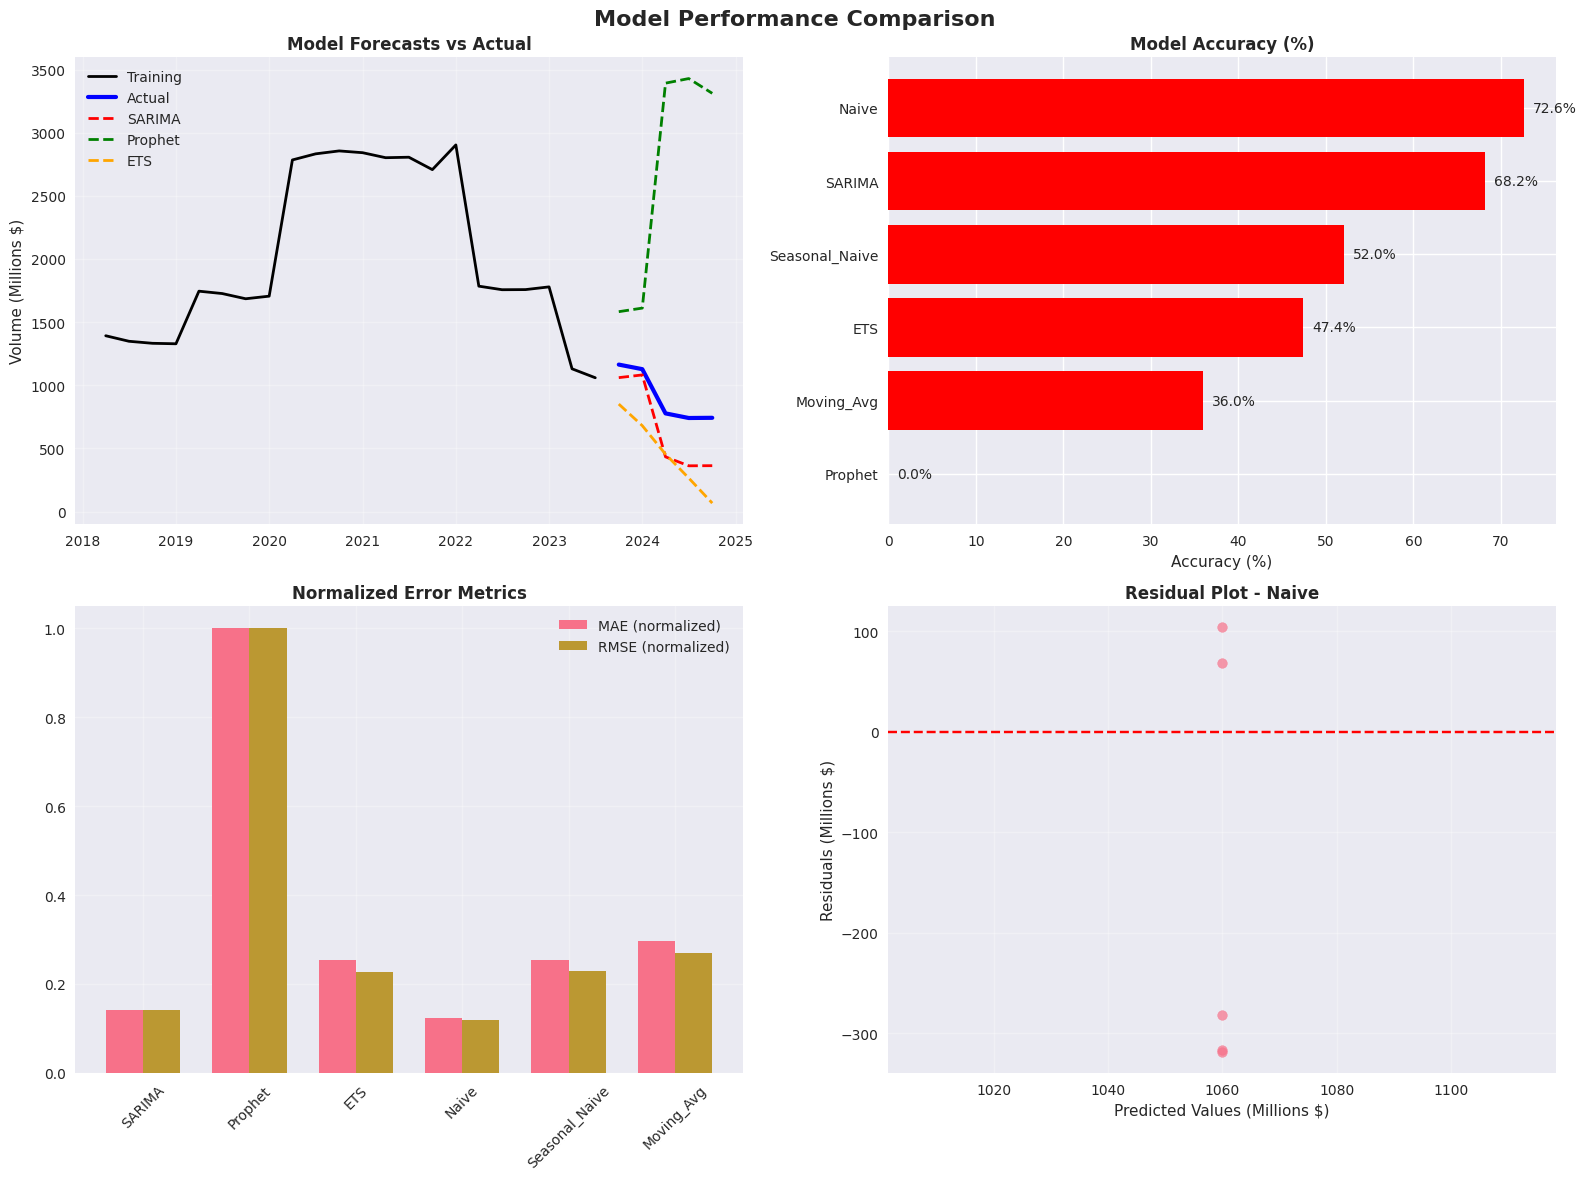

In [9]:
def plot_model_comparison(train_data, test_data, forecasts_dict, evaluation_df):
    """Create comprehensive model comparison plots"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # Plot 1: All forecasts vs actual
    axes[0,0].plot(train_data.index, train_data.values / 1e6, 
                   label='Training', color='black', linewidth=2)
    axes[0,0].plot(test_data.index, test_data.values / 1e6, 
                   label='Actual', color='blue', linewidth=3)
    
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, (model_name, forecast) in enumerate(forecasts_dict.items()):
        if model_name in ['SARIMA', 'Prophet', 'ETS']:  # Only show main models for clarity
            axes[0,0].plot(forecast.index, forecast.values / 1e6, 
                          label=model_name, linestyle='--', linewidth=2, color=colors[i])
    
    axes[0,0].set_title('Model Forecasts vs Actual', fontweight='bold')
    axes[0,0].set_ylabel('Volume (Millions $)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy comparison
    accuracy_data = evaluation_df['Accuracy'].sort_values(ascending=True)
    bars = axes[0,1].barh(range(len(accuracy_data)), accuracy_data.values, 
                         color=['red' if x < 85 else 'green' for x in accuracy_data.values])
    axes[0,1].set_yticks(range(len(accuracy_data)))
    axes[0,1].set_yticklabels(accuracy_data.index)
    axes[0,1].set_title('Model Accuracy (%)', fontweight='bold')
    axes[0,1].set_xlabel('Accuracy (%)')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0,1].text(width + 1, bar.get_y() + bar.get_height()/2, 
                      f'{width:.1f}%', ha='left', va='center')
    
    # Plot 3: Error metrics comparison
    error_metrics = evaluation_df[['MAE', 'RMSE']].copy()
    error_metrics = error_metrics.div(error_metrics.max())  # Normalize for comparison
    
    x_pos = np.arange(len(error_metrics))
    width = 0.35
    
    axes[1,0].bar(x_pos - width/2, error_metrics['MAE'], width, label='MAE (normalized)')
    axes[1,0].bar(x_pos + width/2, error_metrics['RMSE'], width, label='RMSE (normalized)')
    
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(error_metrics.index, rotation=45)
    axes[1,0].set_title('Normalized Error Metrics', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Residual analysis for best model
    best_model_name = evaluation_df['Accuracy'].idxmax()
    best_forecast = forecasts_dict[best_model_name]
    
    common_index = test_data.index.intersection(best_forecast.index)
    residuals = test_data.loc[common_index] - best_forecast.loc[common_index]
    
    axes[1,1].scatter(best_forecast.loc[common_index] / 1e6, residuals / 1e6, alpha=0.7)
    axes[1,1].axhline(y=0, color='red', linestyle='--')
    axes[1,1].set_title(f'Residual Plot - {best_model_name}', fontweight='bold')
    axes[1,1].set_xlabel('Predicted Values (Millions $)')
    axes[1,1].set_ylabel('Residuals (Millions $)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create comparison plots
comparison_fig = plot_model_comparison(train_data, test_data, all_forecasts, model_evaluation)
plt.show()

# Save the figure
comparison_fig.savefig('../model_comparison.png', dpi=300, bbox_inches='tight')

## 9. Save Models and Results

In [10]:
import json
import pickle
from pathlib import Path

# Save models
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

try:
    # Save SARIMA model (if it exists)
    if 'sarima_model' in locals():
        with open(models_dir / 'sarima_model.pkl', 'wb') as f:
            pickle.dump(sarima_model, f)
        print("SARIMA model saved")
    else:
        print("SARIMA model not found")
    
    # Save Holt-Winters model (if it exists)
    if 'holtwinters_model' in locals():
        with open(models_dir / 'holtwinters_model.pkl', 'wb') as f:
            pickle.dump(holtwinters_model, f)
        print("Holt-Winters model saved")
    else:
        print("Holt-Winters model not found")
    
    # Save Prophet model (if it exists)
    if 'prophet_model' in locals():
        with open(models_dir / 'prophet_model.json', 'w') as f:
            json.dump(prophet_model, f)
        print("Prophet model saved")
    else:
        print("Prophet model not found")
        
except Exception as e:
    print(f"Error saving models: {e}")

SARIMA model saved
Holt-Winters model not found
Error saving models: Object of type Prophet is not JSON serializable


## 10. Model Insights Summary

In [11]:
print("=" * 70)
print("MODEL BUILDING - KEY INSIGHTS")
print("=" * 70)

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   • Accuracy: {best_accuracy:.2f}%")
print(f"   • MAE: ${model_evaluation.loc[best_model_name, 'MAE']:,.0f}")
print(f"   • RMSE: ${model_evaluation.loc[best_model_name, 'RMSE']:,.0f}")

print(f"\n📊 MODEL RANKING:")
ranked_models = model_evaluation['Accuracy'].sort_values(ascending=False)
for i, (model, accuracy) in enumerate(ranked_models.items(), 1):
    print(f"   {i}. {model}: {accuracy:.2f}%")

print(f"\n💡 RECOMMENDATIONS:")
if best_accuracy >= 90:
    print("   • Excellent model performance achieved")
    print("   • Ready for production forecasting")
elif best_accuracy >= 80:
    print("   • Good model performance")
    print("   • Consider feature engineering for improvement")
else:
    print("   • Moderate performance - investigate data issues")
    print("   • Consider external variables or different approach")

print(f"\n🔮 NEXT STEPS:")
print("   • Proceed to forecasting with the best model")
print("   • Generate future predictions")
print("   • Create deployment pipeline")

print("\n" + "=" * 70)

MODEL BUILDING - KEY INSIGHTS

🏆 BEST PERFORMING MODEL: Naive
   • Accuracy: 72.62%
   • MAE: $217,964,000
   • RMSE: $243,724,975

📊 MODEL RANKING:
   1. Naive: 72.62%
   2. SARIMA: 68.16%
   3. Seasonal_Naive: 52.05%
   4. ETS: 47.40%
   5. Moving_Avg: 36.01%
   6. Prophet: 0.00%

💡 RECOMMENDATIONS:
   • Moderate performance - investigate data issues
   • Consider external variables or different approach

🔮 NEXT STEPS:
   • Proceed to forecasting with the best model
   • Generate future predictions
   • Create deployment pipeline



## Summary

In this model building notebook we:
1. Prepared training and test datasets
2. Built three advanced models: SARIMA, Prophet, and ETS
3. Created baseline models for comparison
4. Evaluated all models using multiple metrics
5. Identified the best performing model
6. Saved models and results for future use

The best model will be used for final forecasting in the next notebook.